In [1]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

In [2]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [3]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/home/mzums/.fastai/data/pascal_2007/train/007322.jpg'), ['dog'])

In [4]:
dblock = DataBlock(blocks = (ImageBlock, MultiCategoryBlock), get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x334,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
                      0., 0., 0., 0., 0.]))

In [5]:
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#1) ['car']

In [6]:
def splitter(df):
    train = df.index[~df['is_valid']].to_list()
    valid = df.index[df['is_valid']].tolist()
    return train, valid

dblock = DataBlock(blocks = (ImageBlock, MultiCategoryBlock), splitter=splitter, get_x = get_x, get_y = get_y, item_tfms = RandomResizedCrop(128, min_scale = 0.35))

dls = dblock.dataloaders(df)

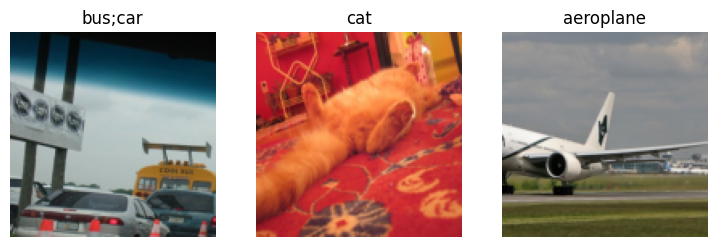

In [7]:
dls.show_batch(nrows=1, ncols=3)

In [8]:
dblock.summary(df)

Setting-up type transforms pipelines
0     000005.jpg           chair      True
1     000007.jpg             car      True
2     000009.jpg    horse person      True
3     000012.jpg             car     False
4     000016.jpg         bicycle      True
...          ...             ...       ...
5006  009954.jpg    horse person      True
5007  009955.jpg            boat      True
5008  009958.jpg  person bicycle      True
5009  009959.jpg             car     False
5010  009961.jpg             dog     False

[5011 rows x 3 columns]
Found 5011 items
2 datasets of sizes 2501,2510
Setting up Pipeline: get_x -> PILBase.create
Setting up Pipeline: get_y -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': False} -> OneHotEncode -- {'c': None}

Building one sample
  Pipeline: get_x -> PILBase.create
    starting from
      fname       000012.jpg
labels             car
is_valid         False
Name: 3, dtype: object
    applying get_x gives
      /home/mzums/.fastai/data/pascal_2007/train

In [9]:
learn = vision_learner(dls, resnet18)

In [10]:
x, y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

In [11]:
activs[0]

TensorImage([-2.7681, -2.9553,  0.0941, -2.1821,  0.2276, -0.6098,  1.5497,
              3.1057,  1.2857, -0.0747,  1.9831, -0.0329, -0.0829, -0.8174,
              0.6448,  0.9497,  0.8215,  0.3313,  1.2453, -2.3912],
            grad_fn=<AliasBackward0>)

In [12]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, inputs, 1-inputs).log().mean()

In [13]:
print(activs.shape)
print(y.shape)

torch.Size([64, 20])
torch.Size([64, 20])


In [14]:
loss_func = nn.BCEWithLogitsLoss()

activs = activs.float()
y = y.float().as_subclass(torch.Tensor)

loss = loss_func(activs, y)
print(loss)


TensorImage(1.0615, grad_fn=<AliasBackward0>)


In [15]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

TensorImage(1.0615, grad_fn=<AliasBackward0>)

In [16]:
def accurace(inp, targ, axis=-1):
    pred = inp.argmax(dim=axis)
    return (pred == targ).float().mean()

In [17]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh) == targ.bool()).float().mean()

In [18]:
learn = vision_learner(dls, resnet50, metrics = partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.952772,0.701832,0.229163,00:06
1,0.825702,0.534065,0.286992,00:05
2,0.599630,0.191427,0.835797,00:05
3,0.356023,0.116727,0.945279,00:05


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.130325,0.103685,0.951614,00:06
1,0.112503,0.095622,0.956972,00:06
2,0.098016,0.093778,0.957948,00:06


In [19]:
learn.metrics = partial(accuracy_multi, thresh=0.5)
learn.validate()

(#2) [0.09377817809581757,0.9675496220588684]

In [20]:
preds, targs = learn.get_preds()

In [21]:
accuracy_multi(preds, targs, thresh=0.5, sigmoid=False)

tensor(0.9675)

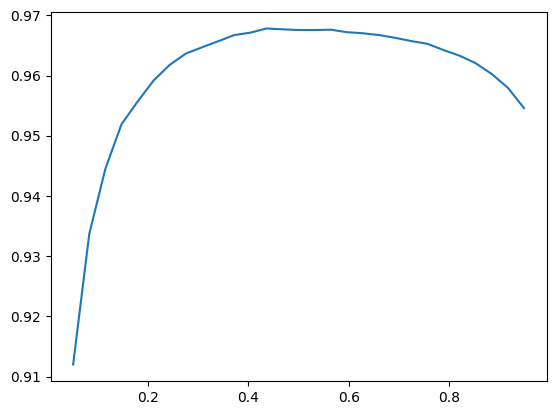

In [22]:
xs = torch.linspace(0.05, 0.95, 29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs, accs)

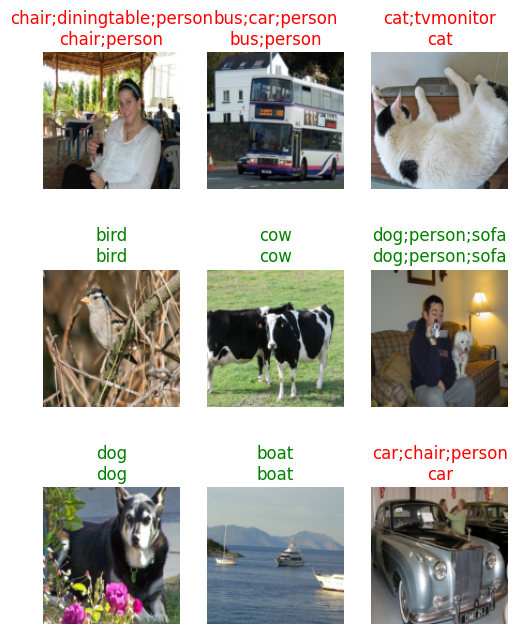

In [31]:
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))